/var/folders/5h/bqx711z52512jrf5xjcc9l8w0000gn/T/ipykernel_8820/1601358896.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01")
[*********************100%***********************]  3 of 3 completed
/var/folders/5h/bqx711z52512jrf5xjcc9l8w0000gn/T/ipykernel_8820/1601358896.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["VFV_ret"] = df["VFV.TO"].pct_change()
/var/folders/5h/bqx711z52512jrf5xjcc9l8w0000gn/T/ipykernel_8820/1601358896.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["AAPL_ret"] = df["AAPL"

              precision    recall  f1-score   support

        High       0.55      0.56      0.56       135
         Low       0.70      0.62      0.66       203
      Medium       0.57      0.63      0.60       197

    accuracy                           0.61       535
   macro avg       0.61      0.60      0.60       535
weighted avg       0.62      0.61      0.61       535

Ticker          VFV.TO        AAPL       GOOGL  High_prob   alert
Date                                                             
2025-10-23  167.190002  259.328583  253.080002   0.463333  YELLOW
2025-10-24  168.679993  262.565491  259.920013   0.326667   GREEN
2025-10-27  170.699997  268.549652  269.269989   0.450000  YELLOW
2025-10-28  170.440002  268.739471  267.470001   0.243333   GREEN
2025-10-29  170.610001  269.438812  274.570007   0.126667   GREEN
2025-10-30  169.339996  271.137146  281.480011   0.146667   GREEN
2025-10-31  170.279999  270.108154  281.190002   0.186667   GREEN
2025-11-03  170.800003  2

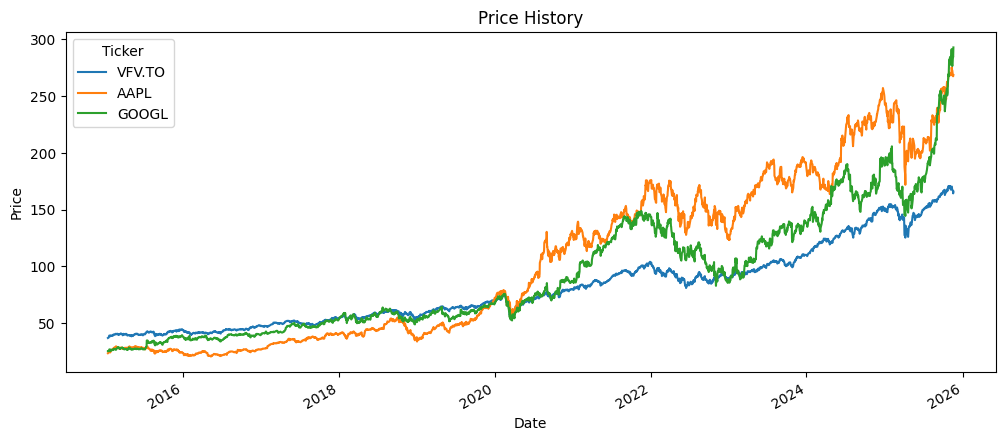

In [14]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. DOWNLOAD DATA
# -----------------------------------------
tickers = ["VFV.TO", "AAPL", "GOOGL"]
data = yf.download(tickers, start="2015-01-01")

df = data["Close"].copy()

# -----------------------------------------
# 2. RETURNS
# -----------------------------------------
df["VFV_ret"] = df["VFV.TO"].pct_change()
df["AAPL_ret"] = df["AAPL"].pct_change()
df["GOOGL_ret"] = df["GOOGL"].pct_change()

# -----------------------------------------
# 3. VOLATILITY (10-day rolling std)
# -----------------------------------------
df["VFV_vol"] = df["VFV_ret"].rolling(10).std()
df["AAPL_vol"] = df["AAPL_ret"].rolling(10).std()
df["GOOGL_vol"] = df["GOOGL_ret"].rolling(10).std()

# FUTURE VOLATILITY (5 days ahead) — using AAPL now
df["future_vol"] = df["AAPL_vol"].shift(-5)
df = df.dropna()

# -----------------------------------------
# 4. LABELS (Low / Medium / High)
# -----------------------------------------
df["vol_label"] = pd.qcut(
    df["future_vol"], q=3, labels=["Low", "Medium", "High"]
)

# -----------------------------------------
# 5. RSI FUNCTION + RSI COLUMNS
# -----------------------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["VFV_RSI"] = compute_rsi(df["VFV.TO"])
df["AAPL_RSI"] = compute_rsi(df["AAPL"])
df["GOOGL_RSI"] = compute_rsi(df["GOOGL"])

# -----------------------------------------
# 6. FEATURES
# -----------------------------------------
features = [
    "VFV_ret", "AAPL_ret", "GOOGL_ret",
    "VFV_vol", "AAPL_vol", "GOOGL_vol",
    "VFV_RSI", "AAPL_RSI", "GOOGL_RSI"
]

X = df[features]
y = df["vol_label"]

# -----------------------------------------
# 7. TRAIN/TEST SPLIT
# -----------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -----------------------------------------
# 8. MODEL
# -----------------------------------------
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# -----------------------------------------
# 9. ALERT SYSTEM (RED/YELLOW/GREEN)
# -----------------------------------------
probs = model.predict_proba(X_test)
df_test = df.loc[X_test.index].copy()

class_index = list(model.classes_).index("High")
df_test["High_prob"] = probs[:, class_index]

df_test["alert"] = df_test["High_prob"].apply(
    lambda p: "RED" if p > 0.6 else ("YELLOW" if p > 0.4 else "GREEN")
)

print(df_test[["VFV.TO", "AAPL", "GOOGL", "High_prob", "alert"]].tail(20))

# -----------------------------------------
# 10. VISUALIZE PRICE HISTORY
# -----------------------------------------
df[["VFV.TO", "AAPL", "GOOGL"]].plot(figsize=(12,5))
plt.title("Price History")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()
